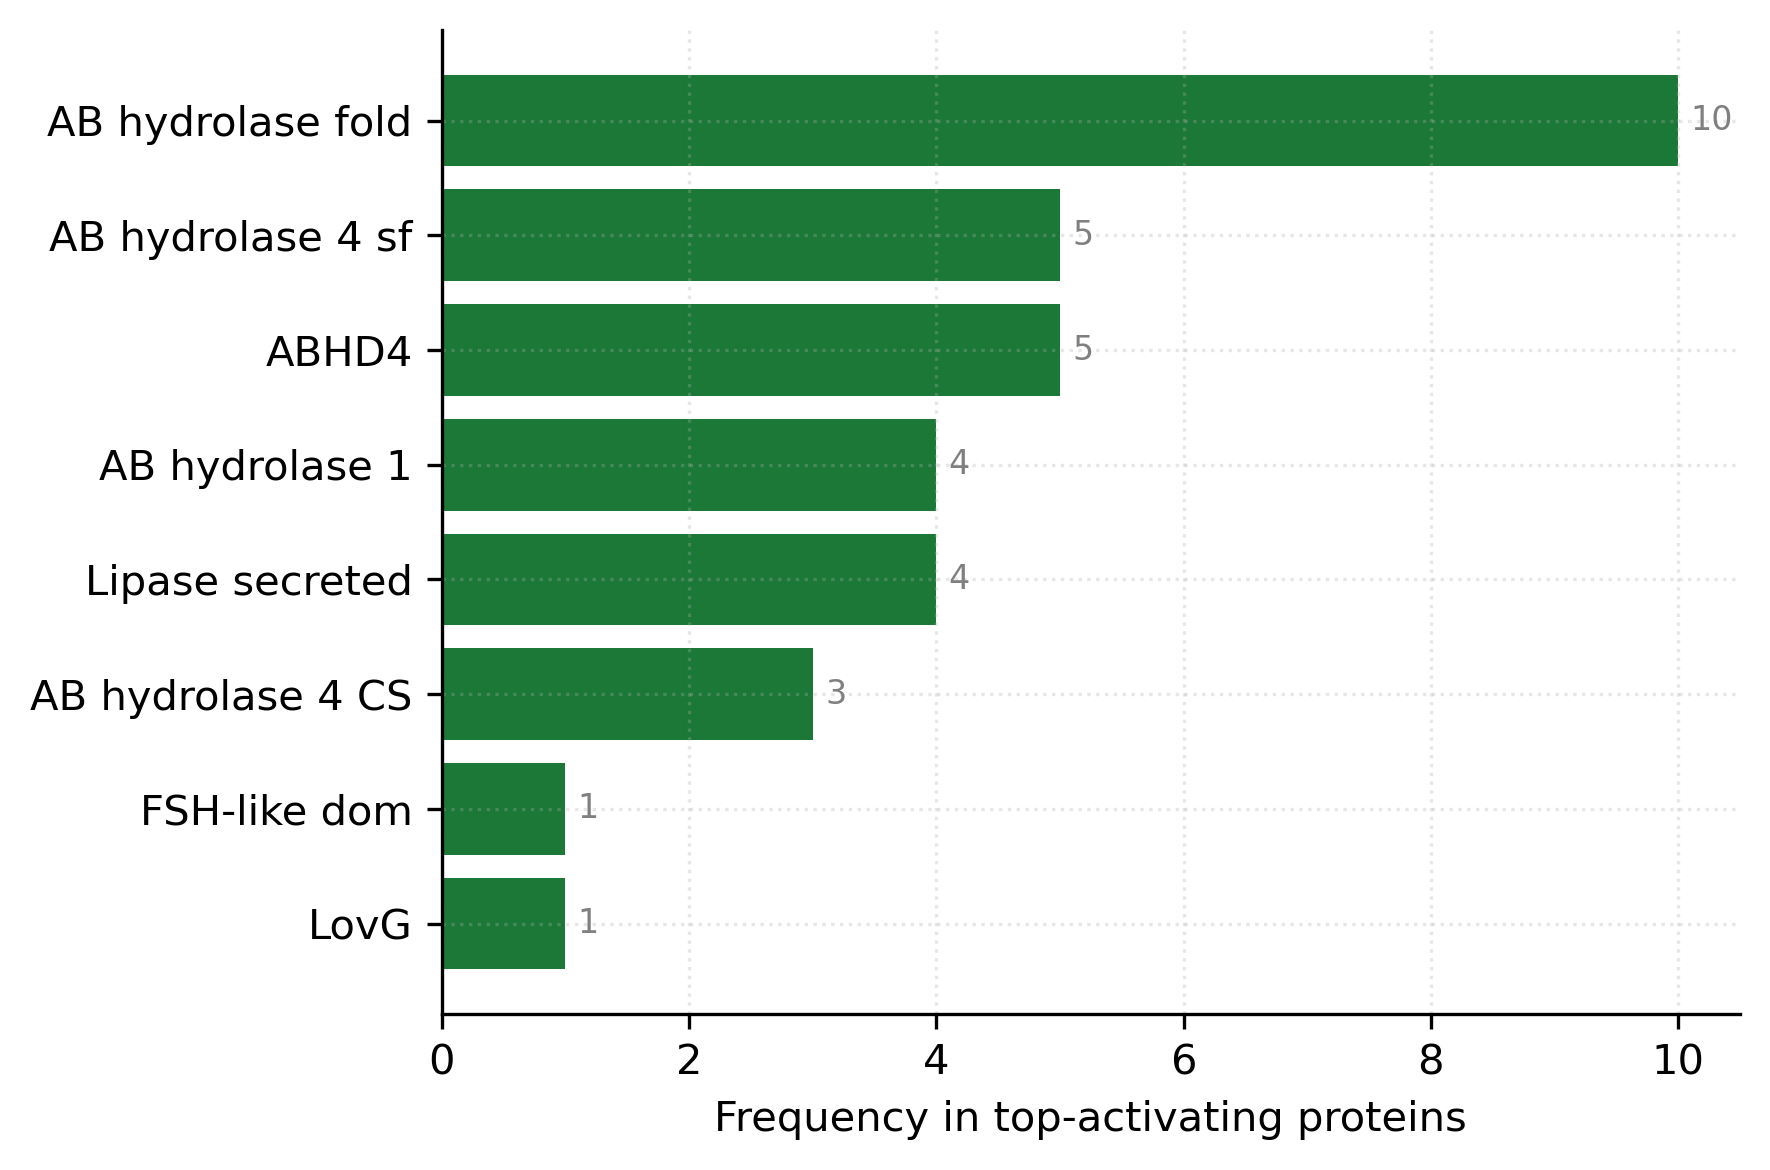

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from textwrap import dedent
import re

# ---------- raw text from the user -----------------
raw = dedent("""
Q24093
IPR000073AB_hydrolase_1
IPR000952AB_hydrolase_4_CS
IPR050960AB_hydrolase_4_sf
IPR029058AB_hydrolase_fold
IPR012020ABHD4

S5ZJC7
IPR029058AB_hydrolase_fold
IPR005152Lipase_secreted

Q5F2F2
IPR050960AB_hydrolase_4_sf
IPR029058AB_hydrolase_fold
IPR012020ABHD4

Q40863
IPR000073AB_hydrolase_1
IPR000952AB_hydrolase_4_CS
IPR050960AB_hydrolase_4_sf
IPR029058AB_hydrolase_fold
IPR012020ABHD4

Q802V6
IPR000073AB_hydrolase_1
IPR050960AB_hydrolase_4_sf
IPR029058AB_hydrolase_fold
IPR012020ABHD4


P45524
IPR000073AB_hydrolase_1
IPR000952AB_hydrolase_4_CS
IPR050960AB_hydrolase_4_sf
IPR029058AB_hydrolase_fold
IPR012020ABHD4

D4AX63
IPR029058AB_hydrolase_fold
IPR005152Lipase_secreted

D9N4H3
IPR029058AB_hydrolase_fold
IPR005152Lipase_secreted

A0A084B9Z4
IPR029058AB_hydrolase_fold
IPR005152Lipase_secreted

W7MWX7
IPR029058AB_hydrolase_fold
IPR005645FSH-like_dom
IPR050593LovG
""").strip().splitlines()

# ---------- parse all InterPro annotations -----------
domain_counts = {}

for line in raw:
    if line.startswith("IPR"):
        # split at the first non-digit character after the 6‑digit IPR code
        match = re.match(r"IPR\d{6}(.*)", line)
        if match:
            domain_name = match.group(1)
            # remove leading/trailing underscores, convert to spaces for readability
            domain_name_clean = domain_name.strip("_").replace("_", " ")
            domain_counts[domain_name_clean] = domain_counts.get(domain_name_clean, 0) + 1

# ---------- build dataframe for plotting -------------
df = pd.DataFrame(
    sorted(domain_counts.items(), key=lambda x: x[1], reverse=True),
    columns=["Domain", "Count"]
)

# ---------- plot -------------------------------------
plt.figure(figsize=(6, 4), dpi=300)
plt.barh(df["Domain"], df["Count"], color="#1b7837")
plt.gca().invert_yaxis()
plt.xlabel("Frequency in top‑activating proteins")
# plt.title("InterPro annotations among top‑10 protein\nLayer 12, 2112", y = 0.95)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
for idx, (cnt) in enumerate(df["Count"]):
    plt.text(cnt + 0.1, idx, str(cnt), va="center", fontsize=8, color="gray")

plt.tight_layout()

# Save in high resolution
import os
os.makedirs("../results", exist_ok=True)

# Save as PNG with high DPI
plt.savefig("../results/l12_2112_top10_domain_histogram.png", 
           dpi=300, bbox_inches='tight', facecolor='white')

# Save as PDF (vector format)
plt.savefig("../results/l12_2112_top10_domain_histogram.pdf", 
           bbox_inches='tight', facecolor='white')

plt.show()


In [24]:
df["Domain"]

0    AB hydrolase fold
1    AB hydrolase 4 sf
2                ABHD4
3       AB hydrolase 1
4      Lipase secreted
5    AB hydrolase 4 CS
6         FSH-like dom
7                 LovG
Name: Domain, dtype: object

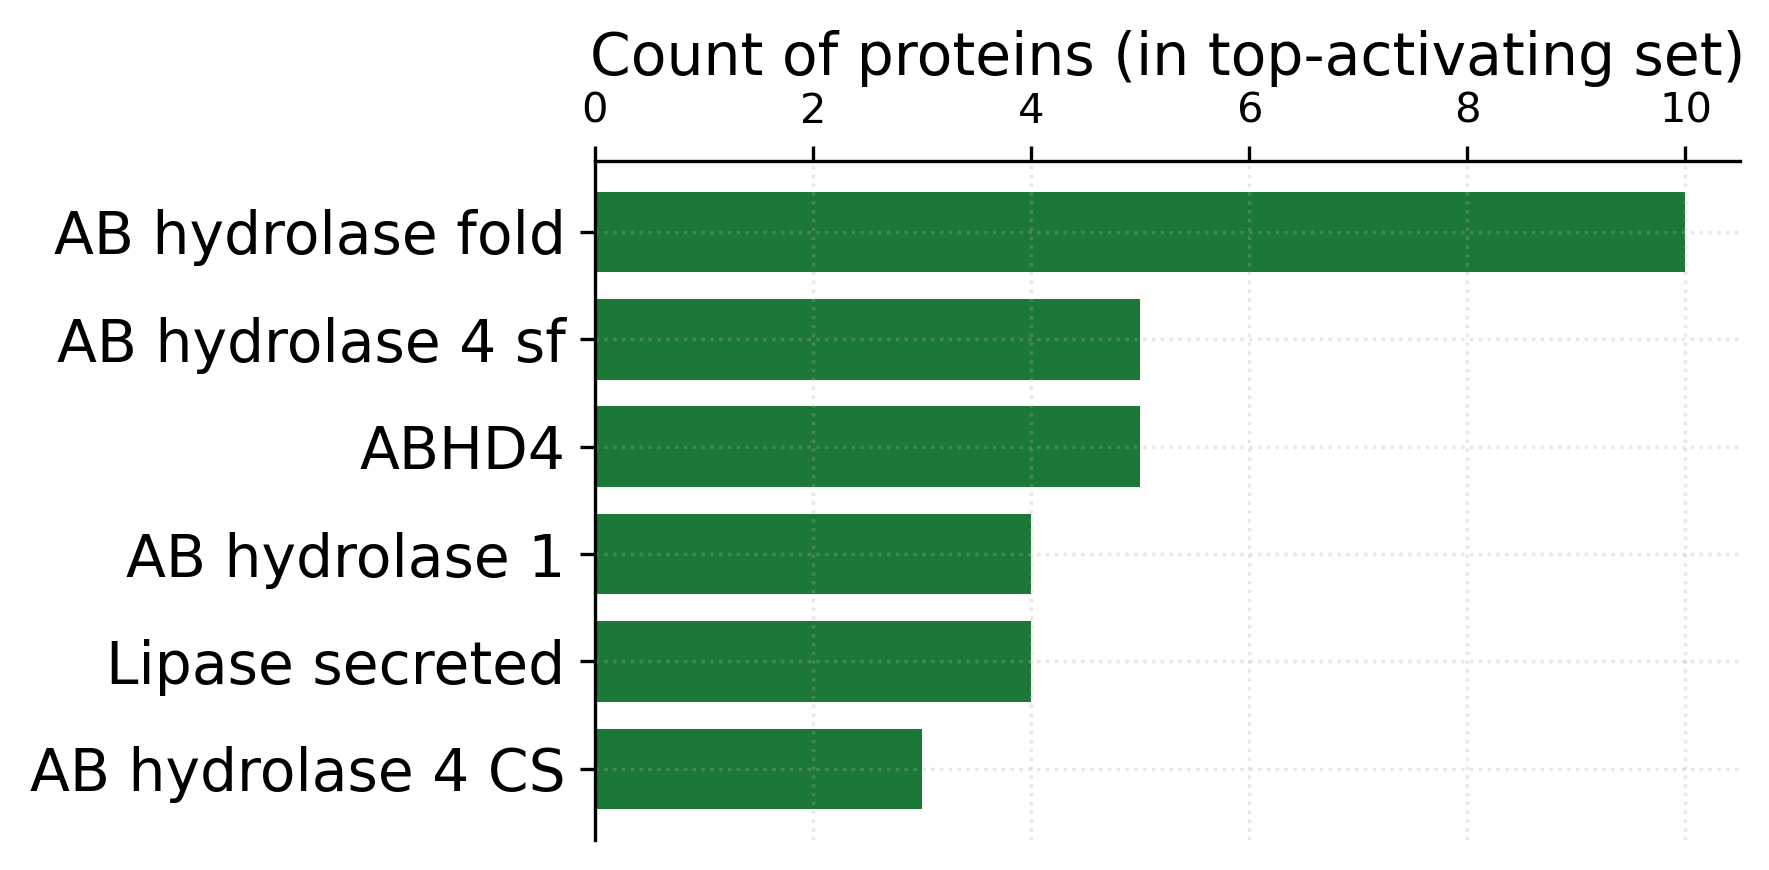

In [34]:
plt.figure(figsize=(6, 3), dpi=300)
plt.barh(df["Domain"][:6], df["Count"][:6], color="#1b7837", height=0.75)
plt.gca().invert_yaxis()
plt.xlabel("Count of proteins (in top-activating set)", fontsize=14)
# plt.title("InterPro annotations among top‑10 protein\nLayer 12, 2112", y = 0.95)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.yticks([])
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
# plt.xticks([])
plt.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
# for idx, (cnt) in enumerate(df["Count"][:6]):
#     plt.text(cnt + 0.1, idx, str(cnt), va="center", fontsize=10, color="black")
plt.tight_layout()
plt.show()

In [2]:
import sys

sys.path.append('../plm_circuits')

# Import utility functions
from helpers.utils import (
    clear_memory,
    load_esm,
    load_sae_prot,
    mask_flanks_segment,
    patching_metric,
    cleanup_cuda
)

import helpers.protein_viz_utils as viz

import torch
import numpy as np
import json
from functools import partial

In IPython
Set autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
In IPython
Set autoreload


In [3]:

# Setup device and load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ESM-2 model
esm_transformer, batch_converter, esm2_alphabet = load_esm(33, device=device)

# Load SAEs for multiple layers
main_layers = [4, 8, 12, 16, 20, 24, 28]
saes = []
for layer in main_layers:
    sae_model = load_sae_prot(ESM_DIM=1280, SAE_DIM=4096, LAYER=layer, device=device)
    saes.append(sae_model)

layer_2_saelayer = {layer: layer_idx for layer_idx, layer in enumerate(main_layers)}

Using device: cuda


In [4]:

# Load sequence data and define protein parameters
with open('../data/full_seq_dict.json', "r") as json_file:
    seq_dict = json.load(json_file)

# Define protein-specific parameters
sse_dict = {"2B61A": [[182, 316]], "1PVGA": [[101, 202]]}
fl_dict = {"2B61A": [44, 43], "1PVGA": [65, 63]}

# Choose protein for analysis
protein = "2B61A"
seq = seq_dict[protein]
position = sse_dict[protein][0]

# Define segment boundaries
ss1_start = position[0] - 5 
ss1_end = position[0] + 5 + 1 
ss2_start = position[1] - 5 
ss2_end = position[1] + 5 + 1 

print(f"Analyzing protein: {protein}")
print(f"Sequence length: {len(seq)}")
print(f"Segment 1: {ss1_start}-{ss1_end}")
print(f"Segment 2: {ss2_start}-{ss2_end}")

Analyzing protein: 2B61A
Sequence length: 377
Segment 1: 177-188
Segment 2: 311-322


In [5]:
# Prepare full sequence and get baseline contact predictions
full_seq_L = [(1, seq)]
_, _, batch_tokens_BL = batch_converter(full_seq_L)
batch_tokens_BL = batch_tokens_BL.to(device)
batch_mask_BL = (batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    full_seq_contact_LL = esm_transformer.predict_contacts(batch_tokens_BL, batch_mask_BL)[0]

# Prepare clean sequence (with optimal flanks)
clean_fl = fl_dict[protein][0]
L = len(seq)
left_start = max(0, ss1_start - clean_fl)
left_end = ss1_start
right_start = ss2_end
right_end = min(L, ss2_end + clean_fl)
unmask_left_idxs = list(range(left_start, left_end))
unmask_right_idxs = list(range(right_start, right_end))

clean_seq_L = mask_flanks_segment(seq, ss1_start, ss1_end, ss2_start, ss2_end, unmask_left_idxs, unmask_right_idxs)
_, _, clean_batch_tokens_BL = batch_converter([(1, clean_seq_L)])
clean_batch_tokens_BL = clean_batch_tokens_BL.to(device)
clean_batch_mask_BL = (clean_batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    clean_seq_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]

print(f"Clean flank size: {clean_fl}")
print(f"Clean sequence contact recovery: {patching_metric(clean_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end):.4f}")

# Prepare corrupted sequence (with suboptimal flanks)
corr_fl = fl_dict[protein][1]
left_start = max(0, ss1_start - corr_fl)
left_end = ss1_start
right_start = ss2_end
right_end = min(L, ss2_end + corr_fl)
unmask_left_idxs = list(range(left_start, left_end))
unmask_right_idxs = list(range(right_start, right_end))

corr_seq_L = mask_flanks_segment(seq, ss1_start, ss1_end, ss2_start, ss2_end, unmask_left_idxs, unmask_right_idxs)
_, _, corr_batch_tokens_BL = batch_converter([(1, corr_seq_L)])
corr_batch_tokens_BL = corr_batch_tokens_BL.to(device)
corr_batch_mask_BL = (corr_batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    corr_seq_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]

print(f"Corrupted flank size: {corr_fl}")
print(f"Corrupted sequence contact recovery: {patching_metric(corr_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end):.4f}")

# Create patching metric function
_patching_metric = partial(
    patching_metric,
    orig_contact=full_seq_contact_LL,
    ss1_start=ss1_start,
    ss1_end=ss1_end,
    ss2_start=ss2_start,
    ss2_end=ss2_end,
)

Clean flank size: 44
Clean sequence contact recovery: 0.5738
Corrupted flank size: 43
Corrupted sequence contact recovery: 0.0279


In [6]:
# Import hook classes
from hook_manager import SAEHookProt

print("Creating layer-wise caches for performance analysis...")

clean_layer_caches = {}
corr_layer_caches = {}
clean_layer_errors = {}
corr_layer_errors = {}

for layer_idx in main_layers:
    sae_model = saes[layer_2_saelayer[layer_idx]]
    
    # Clean caches
    hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, cache_latents=True, 
                       layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        clean_seq_sae_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    print(f"Layer {layer_idx}, clean score: {_patching_metric(clean_seq_sae_contact_LL):.4f}")
    clean_layer_caches[layer_idx] = sae_model.feature_acts
    clean_layer_errors[layer_idx] = sae_model.error_term
    # print shapes
    print(clean_layer_caches[layer_idx].shape, clean_layer_errors[layer_idx].shape)

    # Corrupted caches
    hook = SAEHookProt(sae=sae_model, mask_BL=corr_batch_mask_BL, cache_latents=True, 
                       layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        corr_seq_sae_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    print(f"Layer {layer_idx}, corr score: {_patching_metric(corr_seq_sae_contact_LL):.4f}")
    corr_layer_caches[layer_idx] = sae_model.feature_acts
    corr_layer_errors[layer_idx] = sae_model.error_term

print("Layer-wise caches created successfully!")

Creating layer-wise caches for performance analysis...
Layer 4, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 4, corr score: 0.0279
Layer 8, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 8, corr score: 0.0279
Layer 12, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 12, corr score: 0.0279
Layer 16, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 16, corr score: 0.0279
Layer 20, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 20, corr score: 0.0279
Layer 24, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 24, corr score: 0.0279
Layer 28, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 28, corr score: 0.0279
Layer-wise caches created successfully!


In [40]:
clean_layer_caches[4][:, 3788].shape

torch.Size([379])

In [41]:
clean_layer_caches[4][:, 3788] - corr_layer_caches[4][:, 3788] > 0.3

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [42]:
clean_topk = sae_model.topK_activation(clean_layer_caches[4], k=sae_model.k).cpu().numpy()
corr_topk = sae_model.topK_activation(corr_layer_caches[4], k=sae_model.k).cpu().numpy()

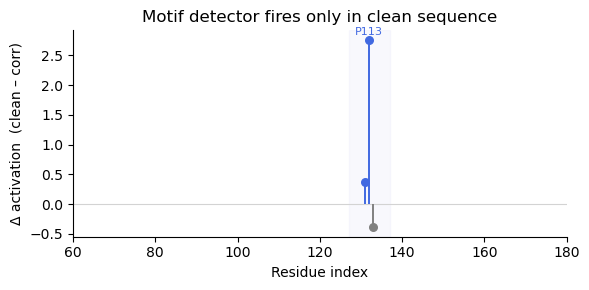

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1.  Pull the activations out of your caches
# -------------------------------------------------
# clean_layer_caches[4] :  [seq_len, n_neurons]
# neuron index you’re showcasing = 3788
clean = clean_layer_caches[4][:, 3788].cpu().numpy() #clean_topk[:, 3788]  #sae_model.topK_activation(clean_layer_caches[4][:, 3788], k=sae_model.k).cpu().numpy()
corr  =  corr_layer_caches[4][:, 3788].cpu().numpy() #sae_model.topK_activation(corr_layer_caches[4][:, 3788], k=sae_model.k).cpu().numpy()
delta = clean - corr                     # Δ activation

# -------------------------------------------------
# 2.  Choose which residues to plot
# -------------------------------------------------
# Either: keep every position whose |Δ| exceeds a fixed threshold …
threshold = 0.30
mask = np.abs(delta) > threshold

# … or, if you prefer: show only the top-k largest changes
# k = 40
# idx_topk = np.argsort(-np.abs(delta))[:k]
# mask = np.zeros_like(delta, dtype=bool)
# mask[idx_topk] = True

x = np.arange(len(delta))[mask]
y = delta[mask]

# -------------------------------------------------
# 3.  Plot lollipops
# -------------------------------------------------
motif_pos = 132        # residue position of the motif centre (0-based; change if needed)

fig, ax = plt.subplots(figsize=(6, 3))
ax.hlines(0, 0, len(delta), color="lightgray", linewidth=0.8, zorder=1)

for xi, yi in zip(x, y):
    color = "royalblue" if yi > 0 else "gray"
    ax.vlines(xi, 0, yi, color=color, linewidth=1.4, zorder=2)
    ax.scatter(xi, yi, color=color, s=30, zorder=3)

# -------------------------------------------------
# 4.  Highlight the motif residue/window
# -------------------------------------------------
ax.axvspan(motif_pos - 5, motif_pos + 5, color="lavender", alpha=0.25, zorder=0)
ax.text(motif_pos, delta[motif_pos] + 0.05*np.sign(delta[motif_pos]),
        "P113", ha="center", va="bottom", fontsize=8, color="royalblue")

# -------------------------------------------------
# 5.  Aesthetics
# -------------------------------------------------
ax.set_xlim(60, 180 ) #len(delta)-1)
ax.set_xlabel("Residue index")
ax.set_ylabel("Δ activation  (clean – corr)")
ax.set_title("Motif detector fires only in clean sequence")
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.show()


In [33]:
seq[0:165]

'GSSHHHHHHSSGLVPRGSHMSVQNVVLFDTQPLTLMLGGKLSYINVAYQTYGTLNDEKNNAVLICHALTGDAEPYFDDGRDGWWQNFMGAGLALDTDRYFFISSNVLGGCKGTTGPSSINPQTGKPYGSQFPNIVVQDIVKVQKALLEHLGISHLKAIIGGSFGG'

In [7]:
import pandas as pd


domain_data = pd.read_csv("reconcile_out_main_gpu/results_reconcile.csv")
domain_data.head()

,layer,unit,domain,aggregator,n_pos,n_neg,auc,ci_lo,ci_hi,U,p_mwu,auc_from_U,auc_matches_U,rho_len_pos,rho_len_neg,qval
0,8,488,IPR029058,max,2937,2957,0.976865,0.973343,0.980161,8483791.5,0.000000e+00,0.976865,True,-0.178210,0.220185,0.000000e+00
1,8,488,IPR029058,topq,2937,2957,0.971083,0.967286,0.974574,8433572.5,0.000000e+00,0.971083,True,-0.559665,0.089352,0.000000e+00
2,8,488,IPR029058,mean,2937,2957,0.641343,0.627377,0.655510,5569878.0,4.292179e-79,0.641343,True,0.138591,0.082591,5.484451e-79
3,8,488,IPR029058,topk,2937,2957,0.851155,0.841406,0.860259,7392031.5,0.000000e+00,0.851155,True,0.385099,0.421938,0.000000e+00
4,8,2677,IPR036188,max,4014,4124,0.986187,0.983326,0.988947,16325082.5,0.000000e+00,0.986187,True,-0.189348,-0.036087,0.000000e+00


In [8]:
metx = [
    (8, 488,  "IPR029058"),
    (8, 2677, "IPR036188"),
    (8, 2775, "IPR009014"),
    (8, 2166, "IPR024072"),
    (12, 2112, "IPR029058"),
    (12, 3536, "IPR029063"),
    (12, 1256, "IPR016181"),
    (12, 2797, "IPR013785"),
    (12, 3794, "IPR029063"),
    (12, 3035, "IPR036322"),
]

top2 = [
    (12, 1082, "PF00867"),
    (12, 2472, "IPR036961"),
    (12, 3943, "IPR036890"),
    (12, 1796, "IPR036890"),
    (12, 1204, "IPR036890"),
    (12, 1145, "IPR036890"),
    (16, 1166, "PF13589"),
    (16, 3077, "IPR036890"),
    (16, 1353, "IPR036890"),
    (16, 1597, "IPR036890"),
    (16, 1814, "IPR036890"),
    (16, 3994, "PF13589"),
    (20, 2311, "PF13589"),
]

def assign_group(row):
    key = (int(row["layer"]), int(row["unit"]), str(row["domain"]))
    if key in metx:
        return "metx"
    if key in top2:
        return "top2"
    return "other"

domain_data["group"] = domain_data.apply(assign_group, axis=1)

In [15]:
print(domain_data["domain"].unique())



['IPR029058' 'IPR036188' 'IPR009014' 'IPR024072' 'IPR029063' 'IPR016181'
 'IPR013785' 'IPR036322' 'PF00867' 'IPR036961' 'IPR036890' 'PF13589']


In [17]:
domain_id2name = {'IPR029058':'AB hydrolase fold', 'IPR036188':'	FAD/NAD', 'IPR009014':'Transketolase', 'IPR024072':'DHFR', 'IPR029063':'	SAM MTases', 'IPR016181':'NAT',
 'IPR013785':'Aldolase', 'IPR036322':'WD40', 'PF00867':'XPG\_I', 'IPR036961':'Kinesin','IPR036890':'HATPase\_C\_sf', 'PF13589':'HATPase\_c\_3'}

In [32]:
agg = 'topk'
grp = 'metx'
sub = domain_data[(domain_data["aggregator"] == agg) & (domain_data["group"] == grp)].sort_values("auc", ascending=False)
yv = np.arange(sub.shape[0])
plt.figure(figsize=(6.0, 0.7*len(yv)))
plt.barh(yv, sub["auc"].values, color="tab:blue", edgecolor="black", height=0.6)
xerr = np.vstack([sub["auc"].values - sub["ci_lo"].values,
                    sub["ci_hi"].values - sub["auc"].values])
plt.errorbar(sub["auc"].values, yv, xerr=xerr, fmt="none", ecolor="black", capsize=5, lw=2)
plt.axvline(0.5, color="grey", ls="--", lw=1)
plt.axvline(0.95, color="grey", ls="--", lw=1)
# labels = [f"L{L}-{U}\n{D}" for L,U,D in zip(sub["layer"], sub["unit"], sub["domain"])]
labels = [f"L{L}-{U}\n{D}" for L,U,D in zip(sub["layer"], sub["unit"], sub["domain"])]
plt.yticks(yv, labels, fontsize=10, fontweight="bold")
plt.xlim(0.4, 1.01)

ax = plt.gca()
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(fontsize=12)

plt.gca().invert_yaxis()
plt.xlabel("AUROC (higher = more selective)", fontsize=14)
# plt.title(f"Selectivity by {agg} (CI = 95% stratified bootstrap)", fontsize=11)
plt.tight_layout()
# plt.show()
out_png = f"auroc_tables/plot_{agg}_{grp}.png"
plt.savefig(out_png, dpi=200)
plt.close()

In [18]:
agg = 'topq'
grp = 'top2'
sub = domain_data[(domain_data["aggregator"] == agg) & (domain_data["group"] == grp)].sort_values("auc", ascending=False)
sub[['layer', 'unit', 'domain', 'aggregator', 'n_pos', 'n_neg', 'auc',
       'ci_lo', 'ci_hi', 
       'rho_len_pos', 'rho_len_neg']].head(30)

,layer,unit,domain,aggregator,n_pos,n_neg,auc,ci_lo,ci_hi,rho_len_pos,rho_len_neg
45,12,2472,IPR036961,topq,221,222,0.997605,0.992295,1.000000,-0.291785,-0.028141
69,16,3077,IPR036890,topq,1700,1737,0.997071,0.994819,0.998885,-0.530454,0.011363
73,16,1353,IPR036890,topq,1700,1737,0.996194,0.993956,0.998126,-0.605785,0.012684
81,16,1814,IPR036890,topq,1700,1737,0.995612,0.992682,0.997955,-0.205905,0.091231
61,12,1145,IPR036890,topq,1700,1737,0.995556,0.993245,0.997594,-0.356481,-0.046506
89,20,2311,PF13589,topq,869,892,0.995412,0.991536,0.998536,0.076101,0.047516
49,12,3943,IPR036890,topq,1700,1737,0.995263,0.992822,0.997419,-0.587701,0.057638
53,12,1796,IPR036890,topq,1700,1737,0.994274,0.991258,0.996815,-0.107438,0.114691
41,12,1082,PF00867,topq,220,223,0.993773,0.982960,1.000000,-0.061831,-0.054597
65,16,1166,PF13589,topq,869,892,0.992408,0.987212,0.996717,0.134697,0.014552


In [13]:
sub.columns

Index(['layer', 'unit', 'domain', 'aggregator', 'n_pos', 'n_neg', 'auc',
       'ci_lo', 'ci_hi', 'U', 'p_mwu', 'auc_from_U', 'auc_matches_U',
       'rho_len_pos', 'rho_len_neg', 'qval', 'group'],
      dtype='object')

In [ ]:
from string import Template
import os
import pandas as pd

# Clean the domain-name map so underscores are handled correctly by LaTeX
domain_id2name_clean = {
    k: (str(v).replace('\\_', '_').strip() if isinstance(v, str) else v)
    for k, v in domain_id2name.items()
}

def fmt_float(x):
    if pd.isna(x):
        return ""
    return f"{x:.3f}".rstrip('0').rstrip('.')

float_cols = ['auc', 'ci_lo', 'ci_hi', 'rho_len_pos', 'rho_len_neg']
formatters = {c: fmt_float for c in float_cols}

out_dir = "auroc_tables"
os.makedirs(out_dir, exist_ok=True)

tpl = Template(r"""
\begin{table}[htbp]
\centering
\caption{Top units by AUC for aggregator ${agg}, group ${grp}}
\label{tab:sub_${agg}_${grp}}
\begin{adjustbox}{max width=\textwidth, max height=\textheight}
$tabular
\end{adjustbox}
\end{table}
""")

for agg in sorted(domain_data['aggregator'].unique()):
    for grp in sorted(domain_data['group'].unique()):
        sub = domain_data[(domain_data['aggregator'] == agg) & (domain_data['group'] == grp)].copy()
        if sub.empty:
            continue

        sub = sub.sort_values("auc", ascending=False)
        sub = sub.rename(columns={'unit': 'latent'})
        sub['domain_name'] = sub['domain'].map(domain_id2name_clean).fillna(sub['domain'])

        cols = [
            'layer', 'latent', 'domain', 'domain_name',
            'n_pos', 'n_neg', 'auc', 'ci_lo', 'ci_hi',
            'rho_len_pos', 'rho_len_neg'
        ]
        view = sub.loc[:, cols]

        tabular = view.to_latex(index=False, escape=True, longtable=False, bold_rows=False, formatters=formatters)

        latex_table = tpl.substitute(agg=agg, grp=grp, tabular=tabular)
        out_path = os.path.join(out_dir, f"sub_table_{agg}_{grp}.tex")
        with open(out_path, "w") as f:
            f.write(latex_table)
        print(f"Wrote {out_path}")

Wrote notebooks/sub_table_max_metx.tex
Wrote notebooks/sub_table_max_top2.tex
Wrote notebooks/sub_table_mean_metx.tex
Wrote notebooks/sub_table_mean_top2.tex
Wrote notebooks/sub_table_topk_metx.tex
Wrote notebooks/sub_table_topk_top2.tex
Wrote notebooks/sub_table_topq_metx.tex
Wrote notebooks/sub_table_topq_top2.tex


In [ ]:
# 1) Rename `unit` -> `latent` and add short domain name next to `domain`
agg = 'topq'
grp = 'top2'
sub = domain_data[(domain_data["aggregator"] == agg) & (domain_data["group"] == grp)].sort_values("auc", ascending=False)
sub = sub.copy()
sub = sub.rename(columns={'unit': 'latent'})
sub['domain_name'] = sub['domain'].map(domain_id2name).fillna(sub['domain'])

# 2) Keep only the requested columns (with `domain_name` right after `domain`)
cols = [
    'layer', 'latent', 'domain', 'domain_name', 'aggregator',
    'n_pos', 'n_neg', 'auc', 'ci_lo', 'ci_hi', 'rho_len_pos', 'rho_len_neg'
]
view = sub.loc[:, cols].copy()

# Optional: tidy numeric formatting for LaTeX
float_cols = ['auc', 'ci_lo', 'ci_hi', 'rho_len_pos', 'rho_len_neg']
view[float_cols] = view[float_cols].round(3)

# 3) Generate a LaTeX table that auto-fits page width/height
tabular = view.to_latex(index=False, escape=True, longtable=False, bold_rows=False)

latex_table = r"""
\begin{table}[htbp]
\centering
\caption{Your caption here}
\label{tab:your_label}
\begin{adjustbox}{max width=\textwidth, max height=\textheight}
%s
\end{adjustbox}
\end{table}
""" % tabular

# Write to file (optional)
with open("sub_table.tex", "w") as f:
    f.write(latex_table)

# Optional: preview top rows in notebook
view.head(30)

,layer,latent,domain,domain_name,aggregator,n_pos,n_neg,auc,ci_lo,ci_hi,rho_len_pos,rho_len_neg
45,12,2472,IPR036961,Kinesin,topq,221,222,0.998,0.992,1.000,-0.292,-0.028
69,16,3077,IPR036890,HATPase\_C\_sf,topq,1700,1737,0.997,0.995,0.999,-0.530,0.011
73,16,1353,IPR036890,HATPase\_C\_sf,topq,1700,1737,0.996,0.994,0.998,-0.606,0.013
81,16,1814,IPR036890,HATPase\_C\_sf,topq,1700,1737,0.996,0.993,0.998,-0.206,0.091
61,12,1145,IPR036890,HATPase\_C\_sf,topq,1700,1737,0.996,0.993,0.998,-0.356,-0.047
89,20,2311,PF13589,HATPase\_c\_3,topq,869,892,0.995,0.992,0.999,0.076,0.048
49,12,3943,IPR036890,HATPase\_C\_sf,topq,1700,1737,0.995,0.993,0.997,-0.588,0.058
53,12,1796,IPR036890,HATPase\_C\_sf,topq,1700,1737,0.994,0.991,0.997,-0.107,0.115
41,12,1082,PF00867,XPG\_I,topq,220,223,0.994,0.983,1.000,-0.062,-0.055
65,16,1166,PF13589,HATPase\_c\_3,topq,869,892,0.992,0.987,0.997,0.135,0.015


In [34]:
index_delta = 132 - 113

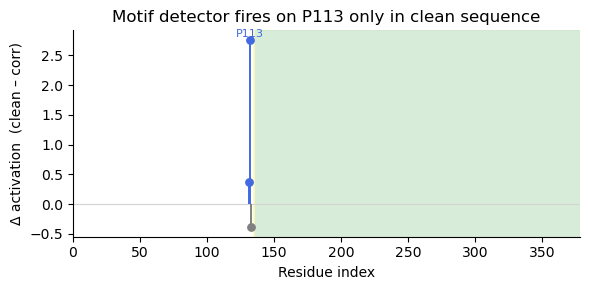

In [35]:
flank_start = 116 + index_delta         # first residue that is always un-masked
motif_pos   = 113 + index_delta         # the causal motif centre

fig, ax = plt.subplots(figsize=(6, 3))

# baseline
ax.hlines(0, 0, len(delta)-1, color="lightgray", lw=0.8, zorder=1)

# lollipops (same as before)
for xi, yi in zip(x, y):
    col = "royalblue" if yi > 0 else "gray"
    ax.vlines(xi, 0, yi, color=col, lw=1.4, zorder=2)
    ax.scatter(xi, yi, color=col, s=28, zorder=3)

# 1️⃣ shade the always-unmasked flank (light mint-green)
ax.axvspan(flank_start, len(delta)-1, color="#c8e6c9", alpha=0.7, zorder=0)
# ax.text(flank_start + 2, ax.get_ylim()[1]*0.95,
#         "Flank un-masked\nin both inputs",
#         fontsize=7, va="top", color="#2e7d32")

# 2️⃣ shade residue 115 (corrupted only)
ax.axvspan(flank_start-1, flank_start, color="#fff9c4", alpha=0.7, zorder=0)
# ax.text(flank_start-0.5, ax.get_ylim()[0]*0.2,
        # "Residue 115\nonly clean",
        # ha="center", va="bottom", fontsize=7, color="#f9a825")

# 3️⃣ motif window (lavender) & label (same as before)
# ax.axvspan(motif_pos-5, motif_pos+5, color="lavender", alpha=0.3, zorder=0)
ax.text(motif_pos, delta[motif_pos]+0.05, "P113", ha="center",
        fontsize=8, color="royalblue")

# house-keeping
ax.set_xlim(0, len(delta)-1)           # or (60, 180) if you still prefer
ax.set_xlabel("Residue index")
ax.set_ylabel("Δ activation  (clean – corr)")
ax.set_title("Motif detector fires on P113 only in clean sequence")
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
# plt.savefig("panel_C_singleAxis.pdf")


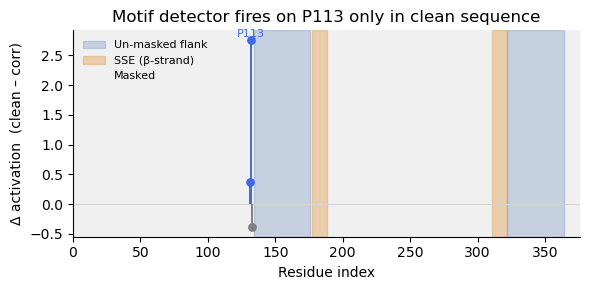

In [36]:
import matplotlib.patches as mpatches

# -------------------------------------------------
# variables you already have
# -------------------------------------------------
L              = len(seq)                 # full length
motif_pos      = 132                      # centre residue for P113
flank_left     = list(range(left_start,  left_end))     # clean left flank idxs
flank_right    = list(range(right_start, right_end))    # clean right flank idxs
sse1_span      = range(ss1_start, ss1_end + 1)
sse2_span      = range(ss2_start, ss2_end + 1)

# -------------------------------------------------
# plot frame
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 3))

# 0)  masked (default) – light grey strip across the whole axis
ax.axvspan(0, L - 1, color="#f0f0f0", zorder=0)

# 1)  always-unmasked flanks (blue)
for span in (flank_left, flank_right):
    if span:
        ax.axvspan(span[0], span[-1], color="#4773b7", alpha=0.25, zorder=0)

# 2)  secondary-structure elements (orange)
for span in (sse1_span, sse2_span):
    ax.axvspan(span.start, span.stop - 1, color="#e0912f", alpha=0.35, zorder=0)

# 3)  baseline and lollipops (unchanged)
ax.hlines(0, 0, L - 1, color="lightgray", lw=0.8, zorder=1)
for xi, yi in zip(x, y):
    col = "royalblue" if yi > 0 else "gray"
    ax.vlines(xi, 0, yi, color=col, lw=1.4, zorder=2)
    ax.scatter(xi, yi, color=col, s=28, zorder=3)

# 4)  motif label
ax.text(motif_pos, delta[motif_pos] + 0.05, "P113",
        ha="center", fontsize=8, color="royalblue")

# 5)  aesthetics
ax.set_xlim(0, L - 1)
ax.set_xlabel("Residue index")
ax.set_ylabel("Δ activation  (clean – corr)")
ax.set_title("Motif detector fires on P113 only in clean sequence")
ax.spines[['right', 'top']].set_visible(False)

# legend — no in-panel text
handles = [
    mpatches.Patch(color="#4773b7",  alpha=0.25, label="Un-masked flank"),
    mpatches.Patch(color="#e0912f",  alpha=0.35, label="SSE (β-strand)"),
    mpatches.Patch(color="#f0f0f0",  alpha=1.00, label="Masked"),
]
ax.legend(handles=handles, frameon=False, fontsize=8, loc="upper left")

plt.tight_layout()
# plt.savefig("panel_C_full.pdf")


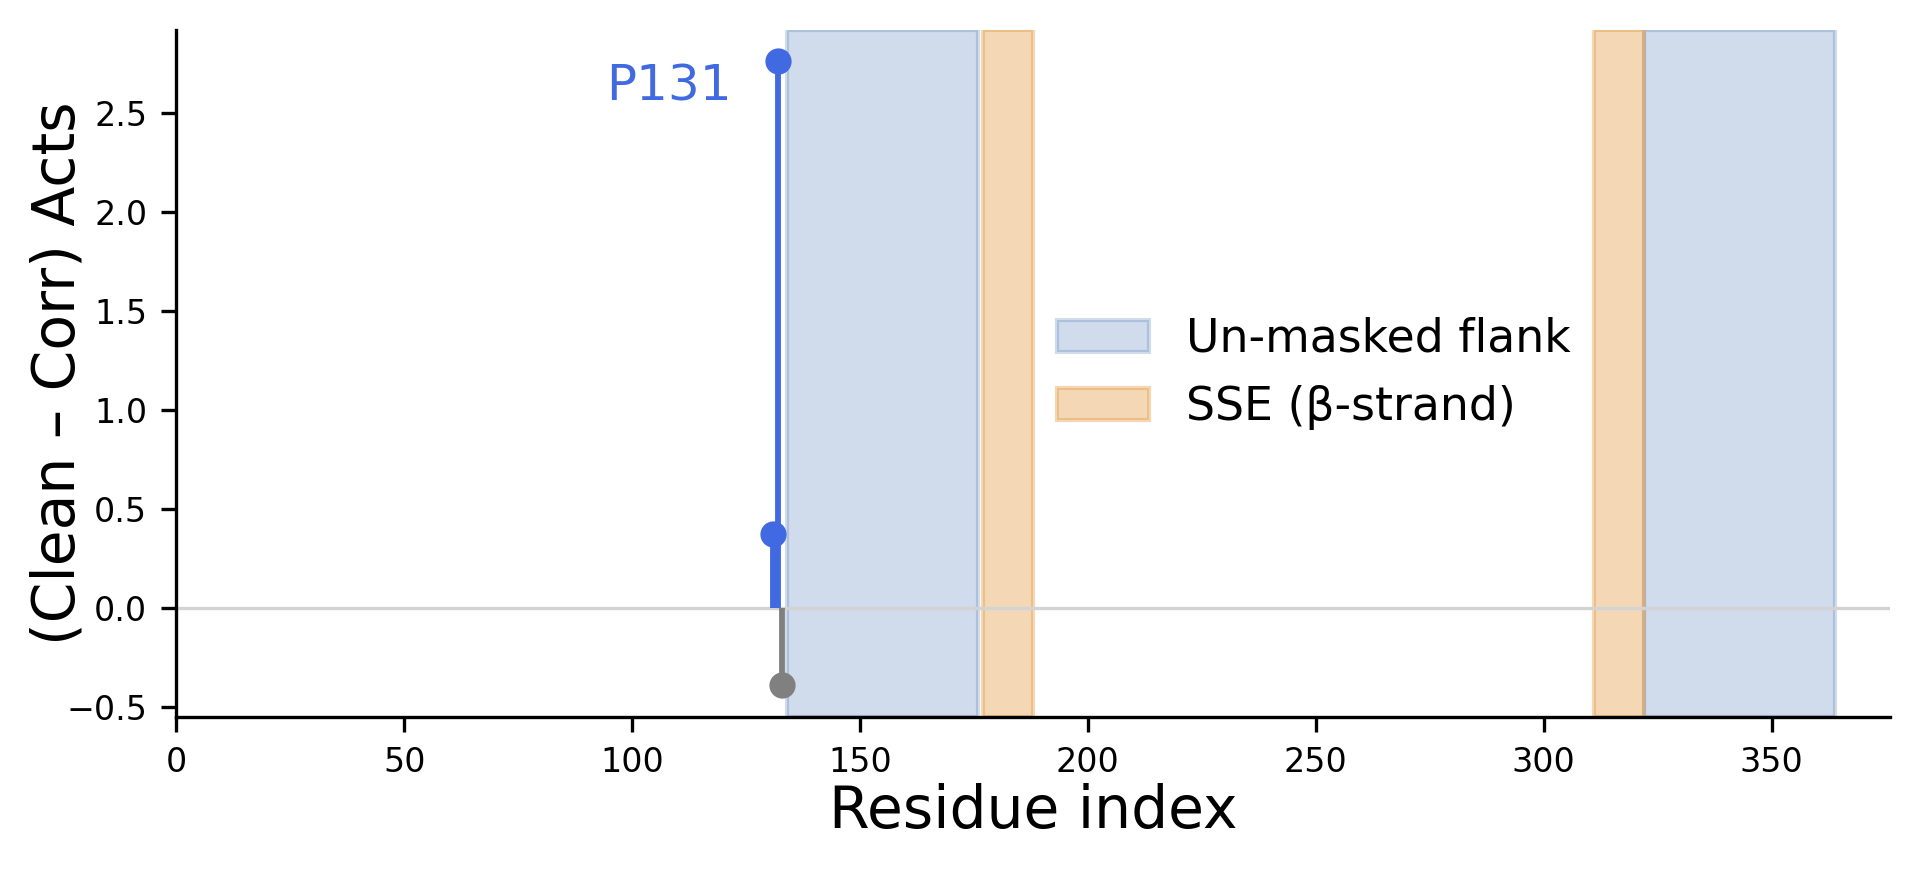

In [39]:
import matplotlib.patches as mpatches

offset = 0 # index_delta            # 19 in your example
L      = len(seq)               # full sequence length

# helper to shift all spans
def span(ax, start, end, **kw):
    ax.axvspan(start - offset, end - offset, **kw)

fig, ax = plt.subplots(figsize=(6.5, 3), dpi=300)
ax.set_facecolor("white")       # kill any pink tint

# 1️⃣   always-unmasked flanks  (blue)
for span_idx in (flank_left, flank_right):
    if span_idx:
        span(ax, span_idx[0], span_idx[-1],
             color="#4773b7", alpha=0.25, zorder=0)

# 2️⃣   SSE (β-strands)         (orange)
for span_idx in (sse1_span, sse2_span):
    span(ax, span_idx.start, span_idx.stop - 1,
         color="#e0912f", alpha=0.35, zorder=0)

# 3️⃣   baseline and lollipops
ax.hlines(0, -offset, L - 1 - offset, color="lightgray", lw=0.8, zorder=1)
for xi, yi in zip(x, y):
    xi_shift = xi - offset
    col      = "royalblue" if yi > 0 else "gray"
    ax.vlines(xi_shift, 0, yi, color=col, lw=1.4, zorder=2)
    ax.scatter(xi_shift, yi, color=col, s=28, zorder=3)

# 4️⃣   motif label
ax.text(motif_pos - offset - 10, delta[motif_pos] - 0.2,
        "P131", ha="right", fontsize=12, color="royalblue")

# 5️⃣   axes & legend
ax.set_xlim(-offset, L - 1 - offset)
ax.set_xlabel(f"Residue index", labelpad=1, fontsize=14) # (−{offset} shift)")
ax.set_ylabel("(Clean – Corr) Acts", labelpad=-5, fontsize=14)
# ax.set_title("Motif detector fires on P113\nonly in clean sequence")
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=8)

handles = [
    mpatches.Patch(color="#4773b7", alpha=0.25, label="Un-masked flank"),
    mpatches.Patch(color="#e0912f", alpha=0.35, label="SSE (β-strand)")
]
ax.legend(handles=handles, frameon=False, fontsize=11, bbox_to_anchor=(0.49, 0.5), loc='center left')

plt.tight_layout()
# plt.savefig("../results/panel_C_clean.pdf")
# plt.savefig("../results/panel_C_clean.png")



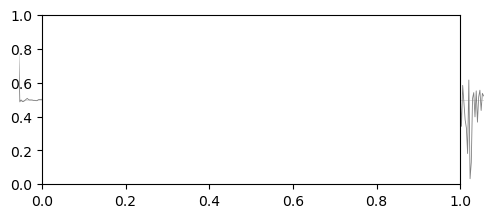

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax_full = plt.subplots(figsize=(6, 2.2))
ax_full.hlines(0, 0, len(delta)-1, color="lightgray", lw=0.5)
ax_full.plot(delta, lw=0.6, color="gray")              # thin line across seq
ax_full.set_xlim(0, len(delta)-1)
ax_full.set_ylim(-0.3, 0.3)                            # keeps it flat
ax_full.axis("off")                                    # minimalist

# highlight motif spike in full view
ax_full.scatter([motif_pos], [delta[motif_pos]], color="royalblue", s=15)

# inset: the lollipop zoom (reuse your lollipop code)
ax_zoom = inset_axes(ax_full, width="100%", height="100%",
                     bbox_to_anchor=(0.05, 0.0, 0.9, 1.0),
                     bbox_transform=ax_full.transAxes, borderpad=0)
# … run the same lollipop drawing commands on ax_zoom …

plt.savefig("panel_C_twin.pdf")
